In [1]:
pip install alpaca_trade_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Initial imports
import os
import requests
import pandas as pd
import warnings
#from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
from MCForecastTools import MCSimulation
from datetime import datetime as dt

%matplotlib inline

In [3]:
# Load .env enviroment variables
#load_dotenv()

Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

btc_url = btc_url + "?format=json"
eth_url = eth_url + "?format=json"

In [6]:
# Fetch current BTC price
btc_price = requests.get(btc_url)

# Fetch current ETH price
eth_price = requests.get(eth_url)

In [7]:
# Extract response / Retrieve output for BTC & ETH in order to get names of rows
btc_response = btc_price.content
eth_response = eth_price.content

# Convert output to JSON
btc_data = btc_price.json()
eth_data = eth_price.json()

In [8]:
# Fetch prices of both BTC and ETH in order to compute total value of crypto portfolio
btc_price = btc_data['data']['1']['quotes']['USD']['price']
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crypto
total_btc_value = my_btc * btc_price
total_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${total_btc_value:0.2f}.")
print(f"The current value of your {my_eth} ETH is ${total_eth_value:0.2f}.")

The current value of your 1.2 BTC is $23149.15.
The current value of your 5.3 ETH is $6913.32.


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)


In [9]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [10]:
os.environ["ALPACA_API_KEY"] ="PK41VCB84QRBQ0YCTDQU"
os.environ["ALPACA_SECRET_KEY"] = "R3S0QvH5lWTvzHMJZmfyEFvP0bq2Cc0QVgf4r0ME"

In [11]:
# Setting the variables for the Alpaca API and secret keys.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Checking that the values were imported correctly by evaluating the type.
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Creating the Alpaca tradeapi.REST object.
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

str

str

Setting the following parameters for the Alpaca API call:
tickers: Use the tickers for the member’s stock and bond holdings.

timeframe: Use a time frame of one day.

start_date and end_date: Use the same date for these parameters, and format them with the date of the previous weekday (or 2020-08-07). This is because you want the one closing price for the most-recent trading day.

In [12]:
# Utility method to convert current date to same date last year
def get_last_year(date):
    # Convert date to list
    date = list(date)
    # Subtract 1 from end of year
    date[3] = str(int(date[3])-1)
    # Return and join date as string
    return ''.join(date)

In [13]:
# Utility method to separate ticker data
def separate_ticker_data(df,ticker):
    # Symbol Column
    symbol = 'symbol'
    # Return DataFrame by ticker and drop several columns
    return df[df[symbol]==ticker].drop(columns=[symbol,'trade_count','vwap'], axis=1)

In [14]:
# Variable for date timezone
timezone = 'America/New_York'

In [15]:
# Utility lambda method to concatenate DataFrames
concatinate_dfs = lambda dataframes: pd.concat(dataframes, axis=1, join='inner', keys=["AGG", "SPY"])

In [16]:
# Format current date as ISO format
iso_date_today = pd.Timestamp(dt.today().strftime('%Y-%m-%d'), tz=timezone).isoformat()
iso_date_last_year = get_last_year(iso_date_today)

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
spy_agg_df = alpaca.get_bars(tickers,
                                 timeframe,
                                 start=iso_date_last_year,
                                 end=iso_date_today).df
# Reorganize the DataFrame
# Separate ticker data
agg_df = separate_ticker_data(spy_agg_df, tickers[0])
spy_df = separate_ticker_data(spy_agg_df, tickers[1])

# Concatenate the ticker DataFrames
spy_agg_df = concatinate_dfs([agg_df,spy_df])
# Preview DataFrame
spy_agg_df.head()

AGG                                         SPY  \
                             open      high      low   close   volume    open   
timestamp                                                                       
2021-10-19 04:00:00+00:00  114.36  114.3700  114.160  114.16  5036701  448.92   
2021-10-20 04:00:00+00:00  114.17  114.2900  114.060  114.08  6092491  451.16   
2021-10-21 04:00:00+00:00  114.01  114.0400  113.840  113.84  5226723  451.79   
2021-10-22 04:00:00+00:00  113.99  114.1399  113.895  114.06  3525700  453.15   
2021-10-25 04:00:00+00:00  114.06  114.2700  114.060  114.17  8539768  454.24   

                                                              
                              high     low   close    volume  
timestamp                                                     
2021-10-19 04:00:00+00:00  450.700  448.27  450.64  46148147  
2021-10-20 04:00:00+00:00  452.732  451.01  452.41  48861693  
2021-10-21 04:00:00+00:00  453.829  451.31  453.59  40711481  
2021-10-22 04:00:00+00:00  454.670  451.05  453.12  57592817  
2021-10-25 04:00:00+00:00  455.900  452.39  455.55  44443003

In [17]:
# Utility lambda method to get latest closing price
get_latest_close = lambda df: df['close'][-1]

In [18]:
# Pick AGG and SPY close prices
agg_close_price = get_latest_close(agg_df)
spy_close_price = get_latest_close(spy_df)

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $95.02
Current SPY closing price: $371.13


In [19]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $18556.50
The current value of your 200 AGG shares is $19004.00


Savings Health Analysis

In [20]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = total_btc_value +total_eth_value
shares = my_spy_value + my_agg_value

# Create savings DataFrame
df_savings = pd.DataFrame(data=[crypto,shares],index=['crypto', 'shares'], columns=['amount'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,30062.472
shares,37560.500


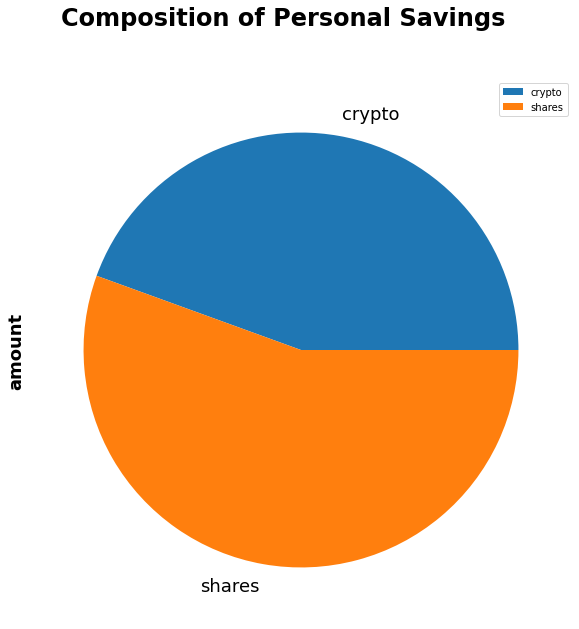

In [21]:
# Plot savings pie chart

# Varible for fontweight
fontweight_bold = 'bold'
# Variable for font size
fontsize_medium = 18

# Plotting Pie Chart
df_savings.plot.pie(y='amount',figsize=(20,10), fontsize=fontsize_medium);

# Setting Plot fontweight
plt.plot(fontweight=fontweight_bold);
# Styling Y Label
plt.ylabel('amount', fontsize=fontsize_medium, fontweight=fontweight_bold);
# Styling title
plt.suptitle('Composition of Personal Savings', fontsize=24, fontweight=fontweight_bold);

In [22]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()

# Validate saving health

# If savings are greater than emergency fund, print congratulations message
if savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund.')
# If savings are equal to emergency fund, print congratulations message
elif savings == emergency_fund:
    print('Congratulations! You have reached your savings goal.')
# Savings are less than emergency fund, print money needed to reach savings goal message
else:
    money_needed = emergency_fund-savings
    print(f'You need ${money_needed} more dollars to reach your savings goal.')

Congratulations! You have enough money in your emergency fund.


Part 2 - Retirement Planning

Monte Carlo Simulation

In [23]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz=timezone).isoformat()
end_date = pd.Timestamp('2021-05-01', tz=timezone).isoformat()

In [24]:
# Get 5 years' worth of historical data for SPY and AGG
spy_agg_df = alpaca.get_bars(tickers, timeframe,
                                    start=start_date,
                                    end=end_date).df

# Reorganize the DataFrame
# Separate ticker data
agg_df = separate_ticker_data(spy_agg_df, tickers[0])
spy_df = separate_ticker_data(spy_agg_df, tickers[1])


# Concatenate the ticker DataFrames
stock_data_df = concatinate_dfs([agg_df,spy_df])

# Display sample data
stock_data_df.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                              SPY                                     
                             open    high     low   close     volume  
timestamp                                                             
2016-05-02 04:00:00+00:00  206.90  208.18  206.41  208.03   61908515  
2016-05-03 04:00:00+00:00  206.50  206.80  205.28  206.13  106422142  
2016-05-04 04:00:00+00:00  205.00  205.85  204.42  204.96   92199810  
2016-05-05 04:00:00+00:00  205.57  205.98  204.47  204.95   67597222  
2016-05-06 04:00:00+00:00  204.04  205.77  203.88  205.70   89131004

In [25]:
# Utility method to return MCSimulation object by years
get_MCSimulation = lambda years: MCSimulation(portfolio_data = stock_data_df,
                                              weights = [.40,.60],
                                              num_simulation = 500,
                                              num_trading_days = 252*years)

In [26]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
monte_carlo_simulation = get_MCSimulation(30)

In [27]:
# Printing the simulation input data
monte_carlo_simulation.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                           SPY                          \
                          daily_return    open    high     low   close   
timestamp                                                                
2016-05-02 04:00:00+00:00          NaN  206.90  208.18  206.41  208.03   
2016-05-03 04:00:00+00:00     0.001808  206.50  206.80  205.28  206.13   
2016-05-04 04:00:00+00:00     0.000451  205.00  205.85  204.42  204.96   
2016-05-05 04:00:00+00:00     0.002526  205.57  205.98  204.47  204.95   
2016-05-06 04:00:00+00:00    -0.001530  204.04  205.77  203.88  205.70   

                                                   
                              volume daily_return  
timestamp                                          
2016-05-02 04:00:00+00:00   61908515          NaN  
2016-05-03 04:00:00+00:00  106422142    -0.009133  
2016-05-04 04:00:00+00:00   92199810    -0.005676  
2016-05-05 04:00:00+00:00   67597222    -0.000049  
2016-05-06 04:00:00+00:00   89131004     0.003659

In [28]:
# Supress warnings
warnings.filterwarnings('ignore')

In [29]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
monte_carlo_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000785,0.996909,1.011595,0.996393,0.998629,0.989226,1.010503,1.007201,1.007491,0.992216,...,1.006752,1.000864,0.985938,0.990660,1.008923,0.994781,0.991976,1.010428,0.998853,0.986944
2,1.013339,0.996438,1.011413,0.998331,0.992722,0.979340,1.003739,1.003550,1.002846,0.997275,...,1.006713,1.008335,0.988392,0.994001,1.007430,0.992504,0.998964,1.013803,1.007168,0.988391
3,1.014256,1.003331,1.006199,0.995811,0.983870,0.980261,0.995435,1.004538,1.001159,1.001882,...,1.002877,1.006550,0.994068,0.997876,1.011146,0.984301,0.999630,1.023422,1.012048,0.988801
4,1.009623,0.998628,0.998225,0.992346,0.981877,0.970639,0.998707,1.013380,0.993996,0.999522,...,0.995521,1.001210,1.001663,1.009875,1.015862,0.995191,1.001286,1.027369,1.013970,0.993874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,27.700489,36.085333,15.194182,14.603649,18.028188,26.486664,14.216954,8.244297,12.045517,8.103720,...,35.456769,24.160976,23.709243,3.676197,6.169898,13.163029,9.920068,58.655506,86.818189,11.021259
7557,27.329232,36.342779,15.264969,14.676105,17.916643,26.784210,14.304195,8.150951,11.967429,8.060379,...,35.831466,24.191572,23.633330,3.697567,6.206319,13.268395,9.926345,57.815680,86.960886,11.048616
7558,27.001376,36.370295,15.226751,14.634908,18.016756,26.769060,14.241012,8.217194,11.951178,8.088068,...,36.136584,24.455147,24.047251,3.673206,6.221099,13.249841,9.947129,58.603961,86.953875,10.963930
7559,26.887738,36.460048,15.278615,14.694864,17.923528,26.446180,14.250215,8.293000,12.087837,7.958199,...,36.062335,24.737958,23.868063,3.694783,6.205674,13.318046,9.925901,58.747578,87.564828,11.034261


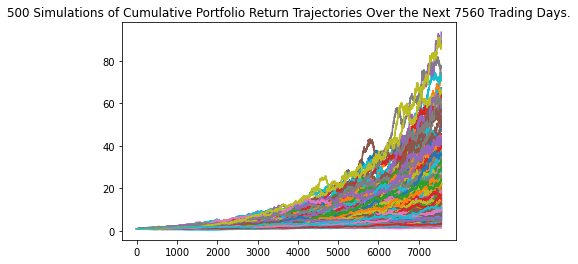

In [30]:
# Plot simulation outcomes
monte_carlo_simulation.plot_simulation();

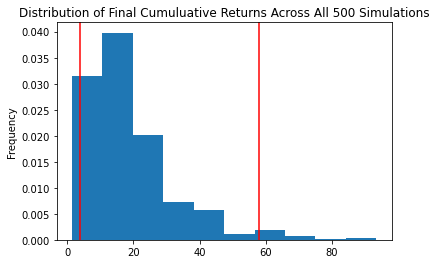

In [31]:
# Plot probability distribution and confidence intervals
monte_carlo_simulation.plot_distribution();

Retirement Analysis

In [32]:
# Fetch summary statistics from the Monte Carlo simulation results
simulation_summary_statistics = monte_carlo_simulation.summarize_cumulative_return()

# Print summary statistics
print(simulation_summary_statistics)

count           500.000000
mean             18.844766
std              13.452810
min               1.440168
25%               9.770630
50%              15.167607
75%              24.297240
max              93.412844
95% CI Lower      3.871815
95% CI Upper     57.837532
Name: 7560, dtype: float64


Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a $20,000 initial investment.

In [33]:
# Utility method to get lower and upper confidence interval multiplied by investment
def calulate_ci_range(investment): 
    # Lambda method to calculate investment times CI rounded to two digits by index
    get_ci_by_investment = lambda index: round(investment * simulation_summary_statistics[index], 2)
    # Returning values for lower and upper CI
    return [get_ci_by_investment(8),get_ci_by_investment(9)]

In [34]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower, ci_upper = calulate_ci_range(initial_investment)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $77436.3 and $1156750.63


Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a 50% increase in the initial investment.

In [35]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower, ci_upper = calulate_ci_range(initial_investment)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $116154.45 and $1735125.95



Optional Challenge - Early Retirement

Five Years Retirement Option

In [36]:

# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
monte_carlo_simulation = get_MCSimulation(5)
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
monte_carlo_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994676,0.999336,1.006518,0.985865,0.996713,0.996721,1.001853,0.997159,0.993451,0.994131,...,1.004049,1.007343,0.994085,0.985329,0.998565,0.987130,1.014103,1.001696,1.012179,1.001428
2,0.989317,0.995854,1.009577,0.990356,0.988972,1.000477,1.011150,0.990215,0.999834,0.998702,...,0.989829,1.008697,0.991263,0.984032,1.005120,0.986876,1.004306,0.994761,1.017967,1.011397
3,0.992537,0.989925,1.010614,0.985528,0.995437,0.999247,1.008586,0.992033,1.011403,0.991708,...,1.000115,1.003412,0.981294,0.969329,1.009634,0.998844,0.996246,1.001712,1.016403,1.010649
4,0.993201,0.992869,0.997316,1.003911,0.996770,1.017383,1.015793,0.999725,1.014772,1.002564,...,1.003337,0.999952,0.983264,0.963326,0.997939,0.995654,1.000054,1.003460,1.008810,1.031581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.871135,1.550158,1.315743,1.761131,2.700162,1.626215,1.158351,1.794651,2.378849,1.371077,...,1.567193,1.633824,2.297140,1.505660,1.215619,2.156616,1.700268,1.281237,0.989905,1.939141
1257,1.866848,1.535221,1.325601,1.751182,2.716400,1.618698,1.148578,1.808573,2.372443,1.368903,...,1.558603,1.625012,2.292907,1.500102,1.216874,2.168897,1.706612,1.278987,0.982763,1.920383
1258,1.879493,1.525303,1.328683,1.740811,2.727847,1.627003,1.154833,1.804019,2.374450,1.373893,...,1.562230,1.615713,2.273994,1.504256,1.213919,2.168228,1.722971,1.277332,0.987219,1.921771
1259,1.889589,1.514545,1.323719,1.748386,2.720493,1.616841,1.150151,1.780950,2.377600,1.382878,...,1.556024,1.621488,2.261603,1.492059,1.203207,2.181533,1.716552,1.280302,0.975608,1.895480


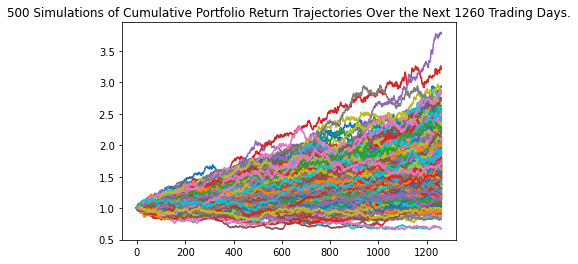

In [37]:
# Plot simulation outcomes
monte_carlo_simulation.plot_simulation();

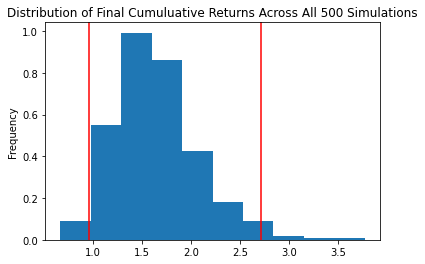

In [38]:

# Plot probability distribution and confidence intervals
monte_carlo_simulation.plot_distribution();

In [39]:

# Fetch summary statistics from the Monte Carlo simulation results
simulation_summary_statistics = monte_carlo_simulation.summarize_cumulative_return()

# Print summary statistics
print(simulation_summary_statistics)

count           500.000000
mean              1.646397
std               0.428060
min               0.669501
25%               1.353367
50%               1.593495
75%               1.875695
max               3.772938
95% CI Lower      0.963368
95% CI Upper      2.713176
Name: 1260, dtype: float64


In [40]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five, ci_upper_five = calulate_ci_range(initial_investment)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57802.09 and $162790.57



Ten Years Retirement Option

In [41]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
monte_carlo_simulation = get_MCSimulation(10)

In [42]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
monte_carlo_simulation.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998745,1.012178,0.984756,1.001940,0.985530,1.005384,0.988041,0.996346,1.001807,0.991475,...,1.004327,0.991592,1.002887,0.993090,0.984781,0.998435,0.995232,1.004877,0.997462,0.998485
2,1.001065,1.005682,0.997744,1.009790,0.978432,0.998476,0.974562,1.001500,0.995232,0.990330,...,1.000375,0.992357,0.993980,0.991463,0.987300,0.978150,1.003986,1.000371,0.988844,1.003193
3,0.986340,1.008235,0.991724,1.007673,0.975987,1.002350,0.970095,1.001552,1.003016,0.997177,...,0.990356,0.982100,0.998075,0.993029,0.991024,0.961908,1.004400,1.011702,0.991084,1.001080
4,0.983589,0.987592,0.988822,1.011662,0.972189,0.994315,0.972133,0.997655,1.003146,1.012194,...,0.995452,0.977381,1.004564,0.977324,0.992638,0.944728,1.013642,1.008134,0.992678,1.006905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.170211,3.052134,2.578826,2.298163,1.986611,1.305055,3.901339,2.031011,2.042546,3.020752,...,3.218777,2.764655,3.939924,1.461415,2.881495,1.707021,0.958488,2.622297,2.561344,2.413119
2517,3.142293,3.036885,2.576698,2.281581,1.996918,1.311091,3.924199,2.029529,2.066751,3.002319,...,3.253358,2.751387,3.988504,1.474754,2.908002,1.725618,0.958998,2.638588,2.590760,2.417101
2518,3.163611,3.036268,2.568778,2.296277,2.013372,1.307001,3.881410,2.018005,2.081452,2.979290,...,3.269235,2.735435,3.977593,1.476237,2.913066,1.730294,0.963697,2.627727,2.589701,2.420439
2519,3.174972,3.018918,2.572177,2.302852,2.009724,1.310767,3.891218,2.027863,2.104967,2.951645,...,3.243498,2.767534,3.946206,1.461409,2.894249,1.736803,0.959411,2.641506,2.573810,2.412710


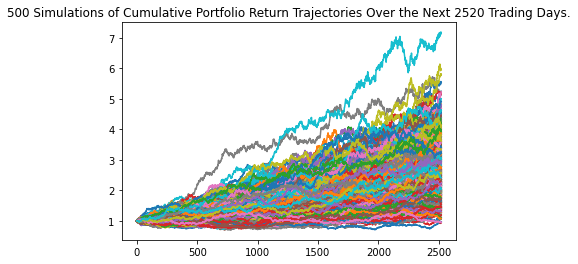

In [43]:
# Plot simulation outcomes
monte_carlo_simulation.plot_simulation();

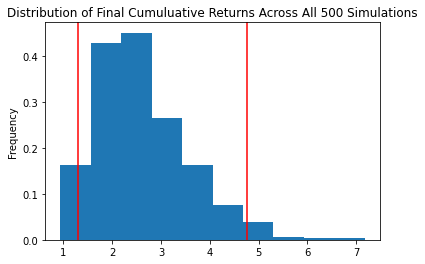

In [44]:
# Plot probability distribution and confidence intervals
monte_carlo_simulation.plot_distribution();

In [45]:

# Fetch summary statistics from the Monte Carlo simulation results
simulation_summary_statistics = monte_carlo_simulation.summarize_cumulative_return()

# Print summary statistics
print(simulation_summary_statistics)

count           500.000000
mean              2.616940
std               0.938329
min               0.935722
25%               1.935424
50%               2.440915
75%               3.187904
max               7.177074
95% CI Lower      1.287836
95% CI Upper      4.766052
Name: 2520, dtype: float64


In [46]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten, ci_upper_ten = calulate_ci_range(initial_investment)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $77270.18 and $285963.15
